Code to evaluate data throughput as we filter on estimated uncertainty

Laurel Hopkins Manella 9/22/2025

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import utils
import time
from scipy.stats import pearsonr, gaussian_kde
import datetime
import cartopy.crs as ccrs
import random
import geopandas as gpd

In [3]:
# Data paths
plot_dir  = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\plots\\uq\\'
#fn =  'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time1_lat2_lon3_min3_dist100.nc' 
fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\harmonized_gosat_v9_to_oco2_v11.1_gosat_oco_collocations_version1a.nc'
tccon_fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_tccon_ggg2020_time1_lat2.5_lon5.0_min15.nc'
full_gosat_fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\harmonized_gosat_v9_to_oco2_v11.1_version1a.nc'

In [4]:
save_plots = False  # whether or not to save plots

In [5]:
# Load GOSAT-OCO-2 collocated data
colloc_data_xr = xr.open_dataset(fn) 
colloc_data = colloc_data_xr.to_dataframe()
colloc_data['gosat_sounding_id'] = colloc_data.index
print(f'{colloc_data.shape[0]} GOSAT-OCO colloacated soundings')
colloc_data_qf0 = colloc_data[colloc_data['gosat_xco2_quality_flag']==0]  # only compare QF=0
print(f'{colloc_data_qf0.shape[0]} QF=0 colloacated soundings')
colloc_data_qf1 = colloc_data[colloc_data['gosat_xco2_quality_flag']==1]  # only compare QF=0

431529 GOSAT-OCO colloacated soundings
205033 QF=0 colloacated soundings


In [6]:
# Split GOSAT-OCO-2 collocated data by surface type and gain
land_h_colloc = colloc_data[(colloc_data['gosat_retrieval_surface_type'] == 1) & 
                                        (colloc_data['gosat_gain'] == 'H')]
land_m_colloc = colloc_data[(colloc_data['gosat_retrieval_surface_type'] == 1) & 
                                        (colloc_data['gosat_gain'] == 'M')]
ocean_h_colloc = colloc_data[(colloc_data['gosat_retrieval_surface_type'] == 0) & 
                                        (colloc_data['gosat_gain'] == 'H')]

In [7]:
# Load TCCON-GOSAT collocated data
tccon_gosat_collocations = xr.open_dataset(tccon_fn)
tccon_gosat_collocations = tccon_gosat_collocations.to_dataframe()
print(f'{tccon_gosat_collocations.shape[0]} TCCON-GOSAT colloacated soundings')
tccon_gosat_collocations_qf0 = tccon_gosat_collocations[tccon_gosat_collocations['gosat_xco2_quality_flag']==0]  # only compare QF=0
print(f'{tccon_gosat_collocations_qf0.shape[0]} QF=0 colloacated soundings')

42221 TCCON-GOSAT colloacated soundings
21092 QF=0 colloacated soundings


In [8]:
# Remap Armstrong and Dryden to Edwards   
tccon_gosat_collocations.loc[tccon_gosat_collocations['tccon_site'] == 'Armstrong', 'tccon_site'] = 'Edwards'
tccon_gosat_collocations.loc[tccon_gosat_collocations['tccon_site'] == 'Dryden', 'tccon_site'] = 'Edwards'

tccon_gosat_collocations_qf0.loc[tccon_gosat_collocations_qf0['tccon_site'] == 'Armstrong', 'tccon_site'] = 'Edwards'
tccon_gosat_collocations_qf0.loc[tccon_gosat_collocations_qf0['tccon_site'] == 'Dryden', 'tccon_site'] = 'Edwards'

In [9]:
# Split TCCON-GOSAT collocated data by surface type and gain
land_h_tccon = tccon_gosat_collocations[(tccon_gosat_collocations['gosat_retrieval_surface_type'] == 1) & 
                                        (tccon_gosat_collocations['gosat_gain'] == 'H')]
land_m_tccon = tccon_gosat_collocations[(tccon_gosat_collocations['gosat_retrieval_surface_type'] == 1) & 
                                        (tccon_gosat_collocations['gosat_gain'] == 'M')]
ocean_h_tccon = tccon_gosat_collocations[(tccon_gosat_collocations['gosat_retrieval_surface_type'] == 0) & 
                                        (tccon_gosat_collocations['gosat_gain'] == 'H')]

In [10]:
# Load full GOSAT record
full_gosat_xr = xr.open_dataset(full_gosat_fn) 
full_gosat = full_gosat_xr.to_dataframe()
full_gosat['gosat_sounding_id'] = full_gosat.index
print(f'{full_gosat.shape[0]} GOSAT soundings')
full_gosat_qf0 = full_gosat[full_gosat['gosat_xco2_quality_flag']==0]  # only compare QF=0
print(f'{full_gosat_qf0.shape[0]} QF=0 GOSAT soundings')

5919450 GOSAT soundings
2019410 QF=0 GOSAT soundings


In [11]:
land_h_full_gosat = full_gosat[(full_gosat['gosat_retrieval_surface_type'] == 1) & 
                                        (full_gosat['gosat_gain'] == 'H')]
land_h_full_gosat_qf0 = land_h_full_gosat[land_h_full_gosat['gosat_xco2_quality_flag']==0]
land_m_full_gosat = full_gosat[(full_gosat['gosat_retrieval_surface_type'] == 1) & 
                                        (full_gosat['gosat_gain'] == 'M')]
land_m_full_gosat_qf0 = land_m_full_gosat[land_m_full_gosat['gosat_xco2_quality_flag']==0]
ocean_h_full_gosat = full_gosat[(full_gosat['gosat_retrieval_surface_type'] == 0) & 
                                        (full_gosat['gosat_gain'] == 'H')]
ocean_h_full_gosat_qf0 = ocean_h_full_gosat[ocean_h_full_gosat['gosat_xco2_quality_flag']==0]


print(land_h_full_gosat.shape)
print(land_h_full_gosat_qf0.shape)
print(land_m_full_gosat.shape)
print(land_m_full_gosat_qf0.shape)
print(ocean_h_full_gosat.shape)
print(ocean_h_full_gosat_qf0.shape)

(3264024, 172)
(699854, 172)
(538900, 172)
(206486, 172)
(2116526, 172)
(1113070, 172)


In [6]:
"""# Make geopandas dataframes for plotting

# All GOSAT soundings collocated to TCCON
gosat_gpd = gpd.GeoDataFrame(
        tccon_gosat_collocations,
        geometry=gpd.points_from_xy(tccon_gosat_collocations.gosat_longitude, tccon_gosat_collocations.gosat_latitude),
        crs="EPSG:4326" # WGS84 geographic coordinate system
)

# TCCON stations
gosat_gpd_qf0 = gpd.GeoDataFrame(
        tccon_gosat_collocations_qf0,
        geometry=gpd.points_from_xy(tccon_gosat_collocations_qf0.gosat_longitude, tccon_gosat_collocations_qf0.gosat_latitude),
        crs="EPSG:4326" # WGS84 geographic coordinate system
)"""

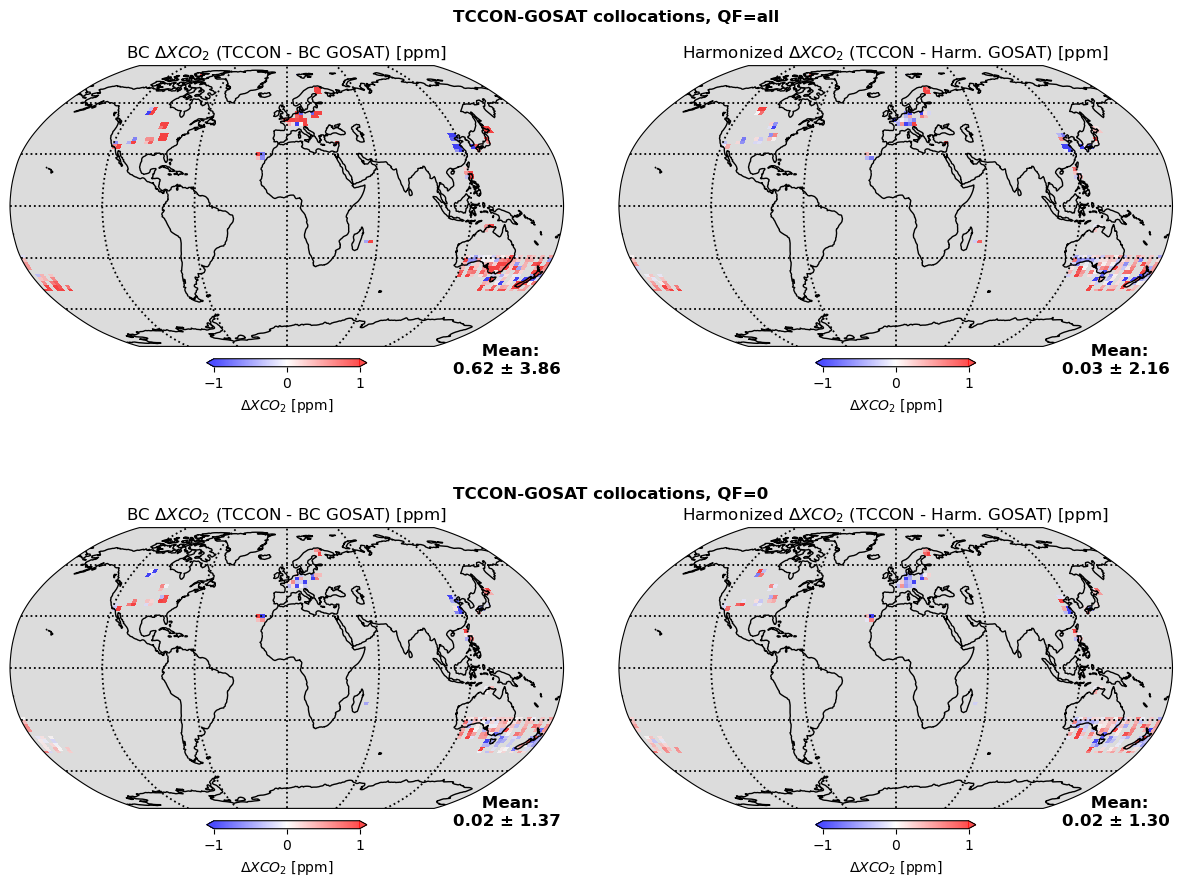

In [16]:
# Spatial plot of TCCON-GOSAT collocations

# Plot QF=all data
diff_bc = tccon_gosat_collocations['tccon_xco2_ak_corrected_mean'].values - tccon_gosat_collocations['gosat_xco2'].values
diff_ml = tccon_gosat_collocations['tccon_xco2_ak_corrected_mean'].values - tccon_gosat_collocations['gosat_xco2_harmonized'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(tccon_gosat_collocations['gosat_longitude'],
                                    tccon_gosat_collocations['gosat_latitude'],
                                    bins=[360//3, 180//3])


# TCCON - BC GOSAT 
d1, _, _, = np.histogram2d(tccon_gosat_collocations['gosat_longitude'],
                           tccon_gosat_collocations['gosat_latitude'],
                           bins=[xedges, yedges], weights=(diff_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.8, 1.2, 'TCCON-GOSAT collocations, QF=all', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     Mean: \n{diff_bc.mean():.2f} ± {diff_bc.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (TCCON - BC GOSAT) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')



# TCCON - Harmonized GOSAT
d1, _, _, = np.histogram2d(tccon_gosat_collocations['gosat_longitude'],
                           tccon_gosat_collocations['gosat_latitude'],
                           bins=[xedges, yedges], weights=(diff_ml))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     Mean: \n{diff_ml.mean():.2f} ± {diff_ml.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (TCCON - Harm. GOSAT) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')




# QF=0 data
diff_bc = tccon_gosat_collocations_qf0['tccon_xco2_ak_corrected_mean'].values - tccon_gosat_collocations_qf0['gosat_xco2'].values
diff_ml = tccon_gosat_collocations_qf0['tccon_xco2_ak_corrected_mean'].values - tccon_gosat_collocations_qf0['gosat_xco2_harmonized'].values


r1, xedges, yedges = np.histogram2d(tccon_gosat_collocations_qf0['gosat_longitude'],
                                    tccon_gosat_collocations_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])


# TCCON - BC GOSAT
d1, _, _, = np.histogram2d(tccon_gosat_collocations_qf0['gosat_longitude'],
                           tccon_gosat_collocations_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(diff_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.8, -0.5, 'TCCON-GOSAT collocations, QF=0', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     Mean: \n{diff_bc.mean():.2f} ± {diff_bc.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (TCCON - BC GOSAT) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')



# TCCON - Harmonized GOSAT 
d1, _, _, = np.histogram2d(tccon_gosat_collocations_qf0['gosat_longitude'],
                           tccon_gosat_collocations_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(diff_ml))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     Mean: \n{diff_ml.mean():.2f} ± {diff_ml.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (TCCON - Harm. GOSAT) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');

if save_plts:
    fig.savefig(os.path.join(plot_dir, f'TCCON-GOSAT_errors.png'))

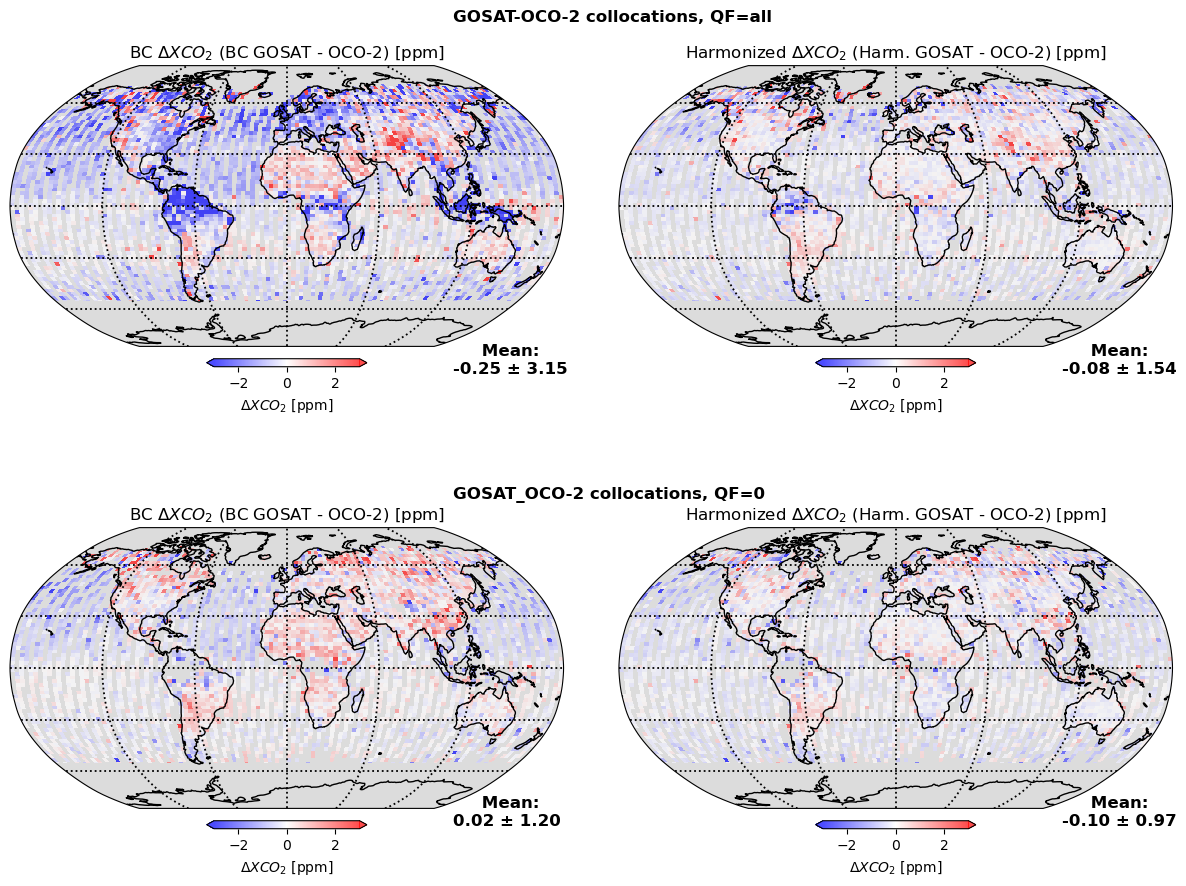

In [18]:
# ALl GOSAT - OCO-2 collocations
# Plot QF=all data 
dxco2_bc = colloc_data['gosat_xco2_ak_corrected'].values - colloc_data['oco2_xco2_mean'].values
dxco2_harm = colloc_data['gosat_xco2_harmonized_ak_corrected'].values - colloc_data['oco2_xco2_mean'].values
#y_ml_uncert = colloc_data_qf0['gosat_xco2_harmonized_uncertainty'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(colloc_data['gosat_longitude'],
                                    colloc_data['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO-2
d1, _, _, = np.histogram2d(colloc_data['gosat_longitude'],
                           colloc_data['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.80, 1.2, 'GOSAT-OCO-2 collocations, QF=all', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     Mean: \n{dxco2_bc.mean():.2f} ± {dxco2_bc.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(colloc_data['gosat_longitude'],
                           colloc_data['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     Mean: \n{dxco2_harm.mean():.2f} ± {dxco2_harm.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# QF=0 data
dxco2_bc = colloc_data_qf0['gosat_xco2_ak_corrected'].values - colloc_data_qf0['oco2_xco2_mean'].values
dxco2_harm = colloc_data_qf0['gosat_xco2_harmonized_ak_corrected'].values - colloc_data_qf0['oco2_xco2_mean'].values

r1, xedges, yedges = np.histogram2d(colloc_data_qf0['gosat_longitude'],
                                    colloc_data_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO02
d1, _, _, = np.histogram2d(colloc_data_qf0['gosat_longitude'],
                           colloc_data_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.80, -0.5, 'GOSAT_OCO-2 collocations, QF=0', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     Mean: \n{dxco2_bc.mean():.2f} ± {dxco2_bc.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')



# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(colloc_data_qf0['gosat_longitude'],
                           colloc_data_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     Mean: \n{dxco2_harm.mean():.2f} ± {dxco2_harm.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');

if save_plots:
    fig.savefig(os.path.join(plot_dir, 'GOSAT-OCO2_collocation_errors.png'))

# LandH - uncertainty thresholding

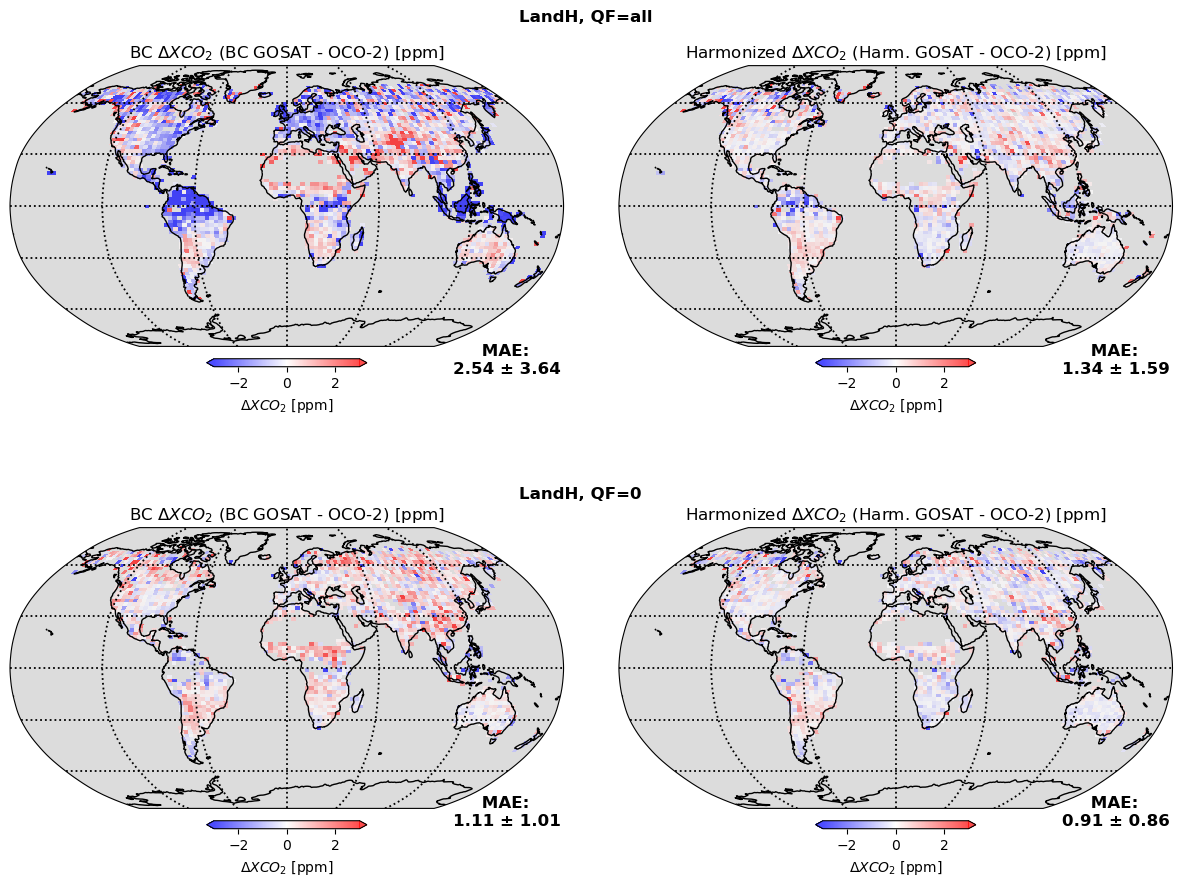

In [70]:
# DXCO2 plots - landH

dxco2_bc = land_h_colloc['gosat_xco2_ak_corrected'].values - land_h_colloc['oco2_xco2_mean'].values
dxco2_harm = land_h_colloc['gosat_xco2_harmonized_ak_corrected'].values - land_h_colloc['oco2_xco2_mean'].values
#y_ml_uncert = colloc_data_qf0['gosat_xco2_harmonized_uncertainty'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(land_h_colloc['gosat_longitude'],
                                    land_h_colloc['gosat_latitude'],
                                    bins=[360//3, 180//3])

# BC GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_colloc['gosat_longitude'],
                           land_h_colloc['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.92, 1.2, 'LandH, QF=all', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_colloc['gosat_longitude'],
                           land_h_colloc['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')




# QF=0 data
land_h_colloc_qf0 = land_h_colloc[land_h_colloc['gosat_xco2_quality_flag']==0]
dxco2_bc = land_h_colloc_qf0['gosat_xco2_ak_corrected'].values - land_h_colloc_qf0['oco2_xco2_mean'].values
dxco2_harm = land_h_colloc_qf0['gosat_xco2_harmonized_ak_corrected'].values - land_h_colloc_qf0['oco2_xco2_mean'].values

r1, xedges, yedges = np.histogram2d(land_h_colloc_qf0['gosat_longitude'],
                                    land_h_colloc_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO02
d1, _, _, = np.histogram2d(land_h_colloc_qf0['gosat_longitude'],
                           land_h_colloc_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.92, -0.5, 'LandH, QF=0', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_colloc_qf0['gosat_longitude'],
                           land_h_colloc_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');

if save_plots:
    fig.savefig(os.path.join(plot_dir, 'GOSAT-OCO2_landH_collocation_errors.png'))

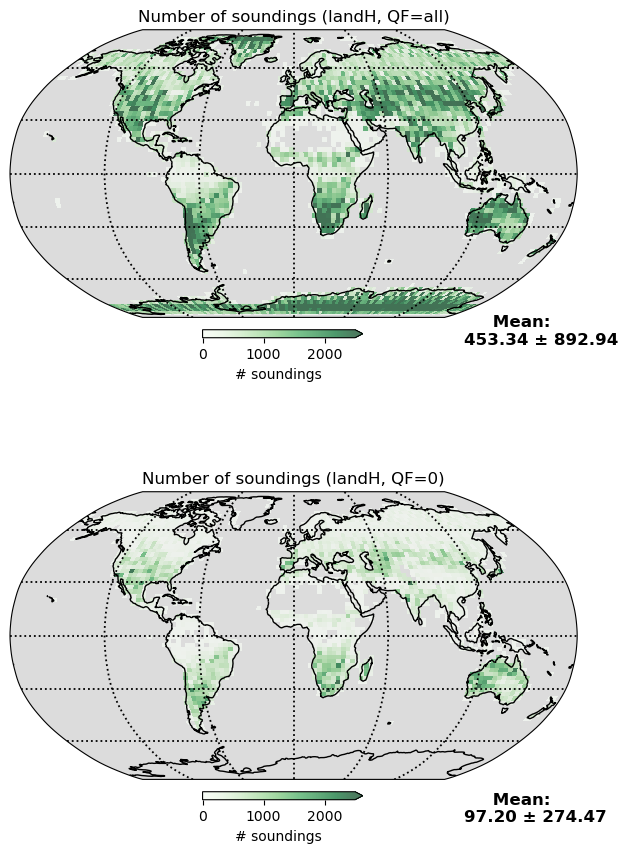

In [13]:
# Plot number of GOSAT soundings 

fig, axs = plt.subplots(2, 1, figsize=(8, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(land_h_full_gosat['gosat_longitude'],
                                    land_h_full_gosat['gosat_latitude'],
                                    bins=[360//3, 180//3])


# QF = all 
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[0].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.8, 0.01, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title('Number of soundings (landH, QF=all)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')


# QF = 0
r1, xedges, yedges = np.histogram2d(land_h_full_gosat_qf0['gosat_longitude'],
                                    land_h_full_gosat_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])


_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[1].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, -1.65, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title('Number of soundings (landH, QF=0)', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'landH_all_counts.png'))

(-0.5, 15.0)

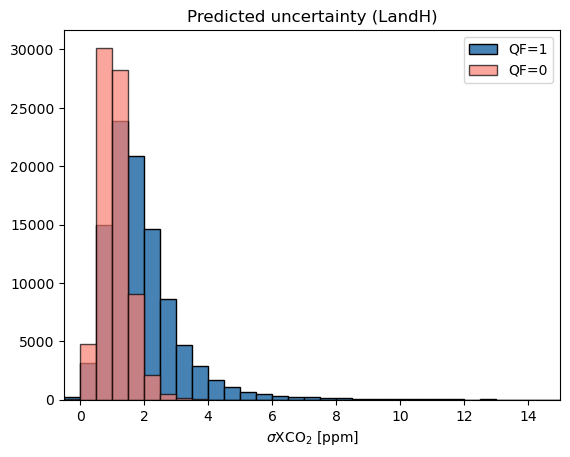

In [16]:
binwidth = 0.5 
bins=np.arange(min(land_h_colloc[land_h_colloc['gosat_xco2_quality_flag']==1]['gosat_xco2_harmonized_uncertainty']), 
           max(land_h_colloc[land_h_colloc['gosat_xco2_quality_flag']==1]['gosat_xco2_harmonized_uncertainty']) + binwidth, binwidth)

plt.hist(land_h_colloc[land_h_colloc['gosat_xco2_quality_flag']==1]['gosat_xco2_harmonized_uncertainty'], bins=bins, 
         label = 'QF=1', edgecolor='black', color='steelblue')
plt.hist(land_h_colloc[land_h_colloc['gosat_xco2_quality_flag']==0]['gosat_xco2_harmonized_uncertainty'], bins=bins, 
         label = 'QF=0', edgecolor='black', color='salmon',alpha=0.7)



plt.title('Predicted uncertainty (LandH, QF=all)')
plt.xlabel(r'$\sigma$XCO$_2$ [ppm]')
plt.legend()
plt.xlim(-0.5, 15)

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'landH_uncertainty_hist.png'))

(-0.5, 5.0)

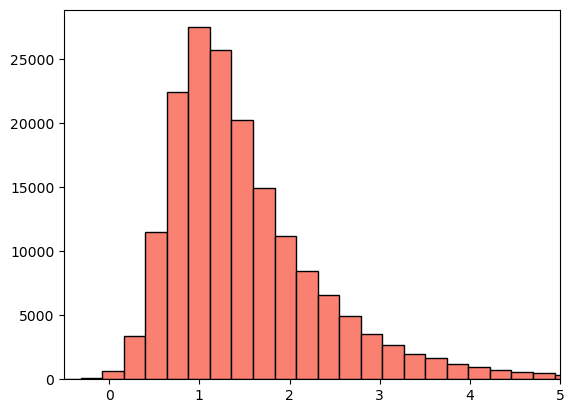

In [17]:
# Use this plot to set sigma thresholds

plt.hist(land_h_colloc['gosat_xco2_harmonized_uncertainty'], bins=100, edgecolor='black', color='salmon')
plt.xlim(-0.5, 5)

In [42]:
# High uncertainty threshold

land_h_high_threshold = 1.8
land_h_high_threshold_df = land_h_colloc[land_h_colloc['gosat_xco2_harmonized_uncertainty'] < land_h_high_threshold]
print(f'High threshold = {land_h_threshold_high}')
print('\nGOSAT-OCO-2 collocations:')
print(f'{(land_h_high_threshold_df.shape[0] / land_h_colloc.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(land_h_colloc[land_h_colloc['gosat_xco2_quality_flag']==0].shape[0] / land_h_colloc.shape[0])*100:.2f}% data throughput')

# Filter full GOSAT record 
land_h_gosat_high_threshold = land_h_full_gosat[land_h_full_gosat['gosat_xco2_harmonized_uncertainty'] < land_h_high_threshold]
print('\nGOSAT full record:')
print(f'{(land_h_gosat_high_threshold.shape[0] / land_h_full_gosat.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(land_h_full_gosat[land_h_full_gosat['gosat_xco2_quality_flag']==0].shape[0] / land_h_full_gosat.shape[0])*100:.2f}% data throughput')

High threshold = 1.8

GOSAT-OCO-2 collocations:
71.63% data throughput
QF=0: 42.99% data throughput

GOSAT full record:
47.07% data throughput
QF=0: 21.44% data throughput


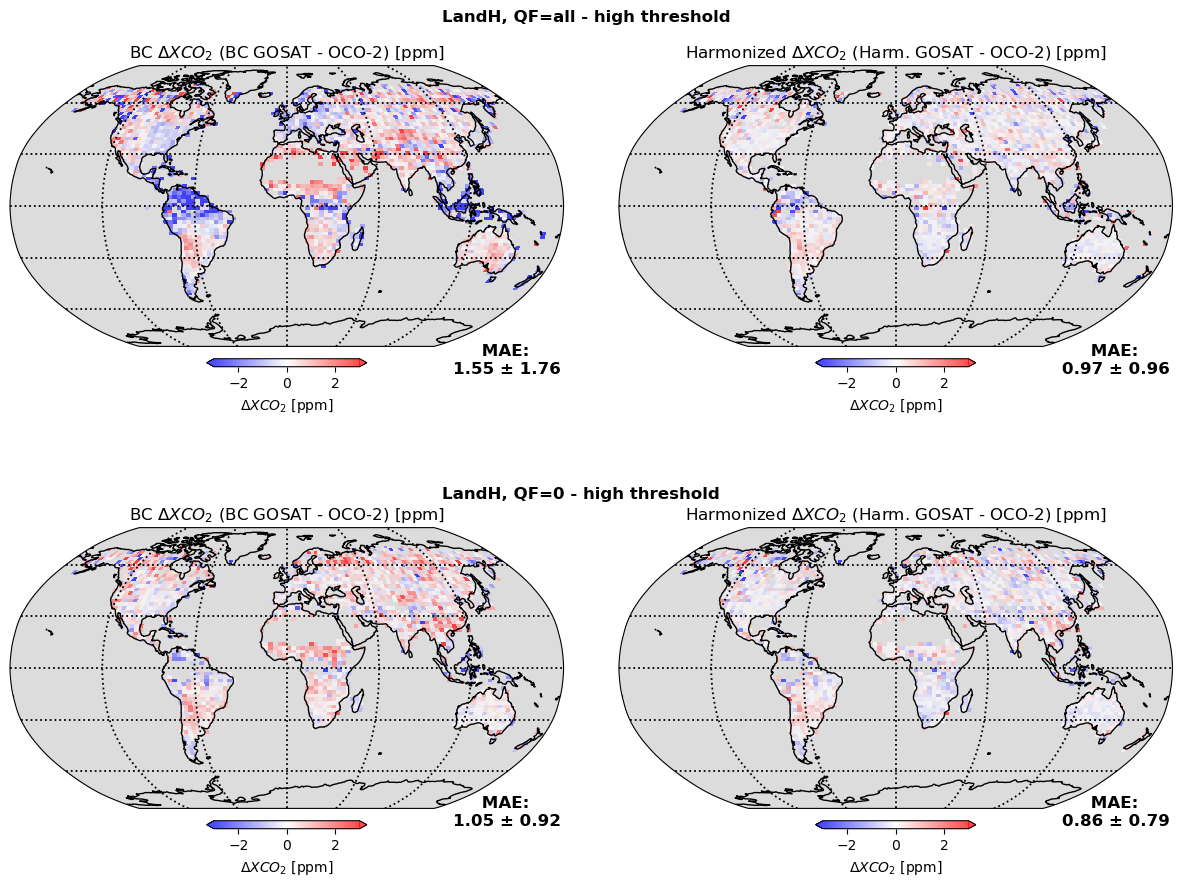

In [34]:
dxco2_bc = land_h_high_threshold_df['gosat_xco2_ak_corrected'].values - land_h_high_threshold_df['oco2_xco2_mean'].values
dxco2_harm = land_h_high_threshold_df['gosat_xco2_harmonized_ak_corrected'].values - land_h_high_threshold_df['oco2_xco2_mean'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(land_h_high_threshold_df['gosat_longitude'],
                                    land_h_high_threshold_df['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_high_threshold_df['gosat_longitude'],
                           land_h_high_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.78, 1.2, f'LandH, QF=all - high threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_high_threshold_df['gosat_longitude'],
                           land_h_high_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')



# QF=0 data
land_h_high_threshold_df_qf0 = land_h_high_threshold_df[land_h_high_threshold_df['gosat_xco2_quality_flag']==0]
dxco2_bc = land_h_high_threshold_df_qf0['gosat_xco2_ak_corrected'].values - land_h_high_threshold_df_qf0['oco2_xco2_mean'].values
dxco2_harm = land_h_high_threshold_df_qf0['gosat_xco2_harmonized_ak_corrected'].values - land_h_high_threshold_df_qf0['oco2_xco2_mean'].values

r1, xedges, yedges = np.histogram2d(land_h_high_threshold_df_qf0['gosat_longitude'],
                                    land_h_high_threshold_df_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO02
d1, _, _, = np.histogram2d(land_h_high_threshold_df_qf0['gosat_longitude'],
                           land_h_high_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.78, -0.5, f'LandH, QF=0 - high threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')



# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_high_threshold_qf0['gosat_longitude'],
                           land_h_high_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'landH_threshold_high_{land_h_high_threshold}_mae.png'))

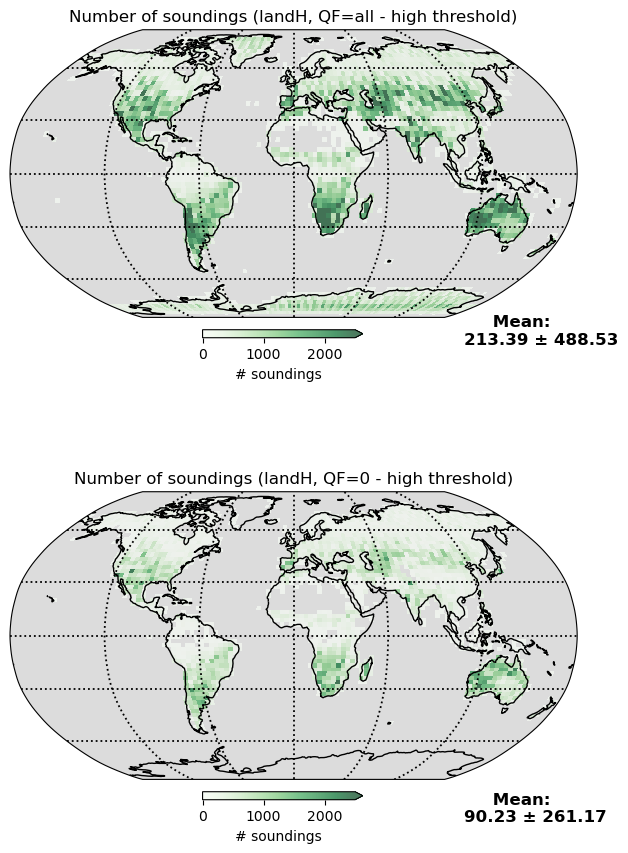

In [40]:
# Plot number of GOSAT soundings after thresholding 

fig, axs = plt.subplots(2, 1, figsize=(8, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

# QF = all 
r1, xedges, yedges = np.histogram2d(land_h_gosat_high_threshold['gosat_longitude'],
                                    land_h_gosat_high_threshold['gosat_latitude'],
                                    bins=[360//3, 180//3])
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[0].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.8, 0.01, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title('Number of soundings (landH, QF=all - high threshold)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')


# QF = 0
land_h_gosat_high_threshold_qf0 = land_h_gosat_high_threshold[land_h_gosat_high_threshold['gosat_xco2_quality_flag']==0]

r1, xedges, yedges = np.histogram2d(land_h_gosat_high_threshold_qf0['gosat_longitude'],
                                    land_h_gosat_high_threshold_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[1].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, -1.65, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title('Number of soundings (landH, QF=0 - high threshold)', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'landH_high_threshold_counts.png'))

In [53]:
# Medium uncertainty threshold

land_h_med_threshold = 1.5
land_h_med_threshold_df = land_h_colloc[land_h_colloc['gosat_xco2_harmonized_uncertainty'] < land_h_med_threshold]
print(f'Medium threshold = {land_h_med_threshold}')
print('\nGOSAT-OCO-2 collocations:')
print(f'{(land_h_med_threshold_df.shape[0] / land_h_colloc.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(land_h_colloc[land_h_colloc['gosat_xco2_quality_flag']==0].shape[0] / land_h_colloc.shape[0])*100:.2f}% data throughput')

# Filter full GOSAT record 
land_h_gosat_med_threshold = land_h_full_gosat[land_h_full_gosat['gosat_xco2_harmonized_uncertainty'] < land_h_med_threshold]
print('\nGOSAT full record:')
print(f'{(land_h_gosat_med_threshold.shape[0] / land_h_full_gosat.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(land_h_full_gosat[land_h_full_gosat['gosat_xco2_quality_flag']==0].shape[0] / land_h_full_gosat.shape[0])*100:.2f}% data throughput')

Medium threshold = 1.5

GOSAT-OCO-2 collocations:
59.92% data throughput
QF=0: 42.99% data throughput

GOSAT full record:
36.28% data throughput
QF=0: 21.44% data throughput


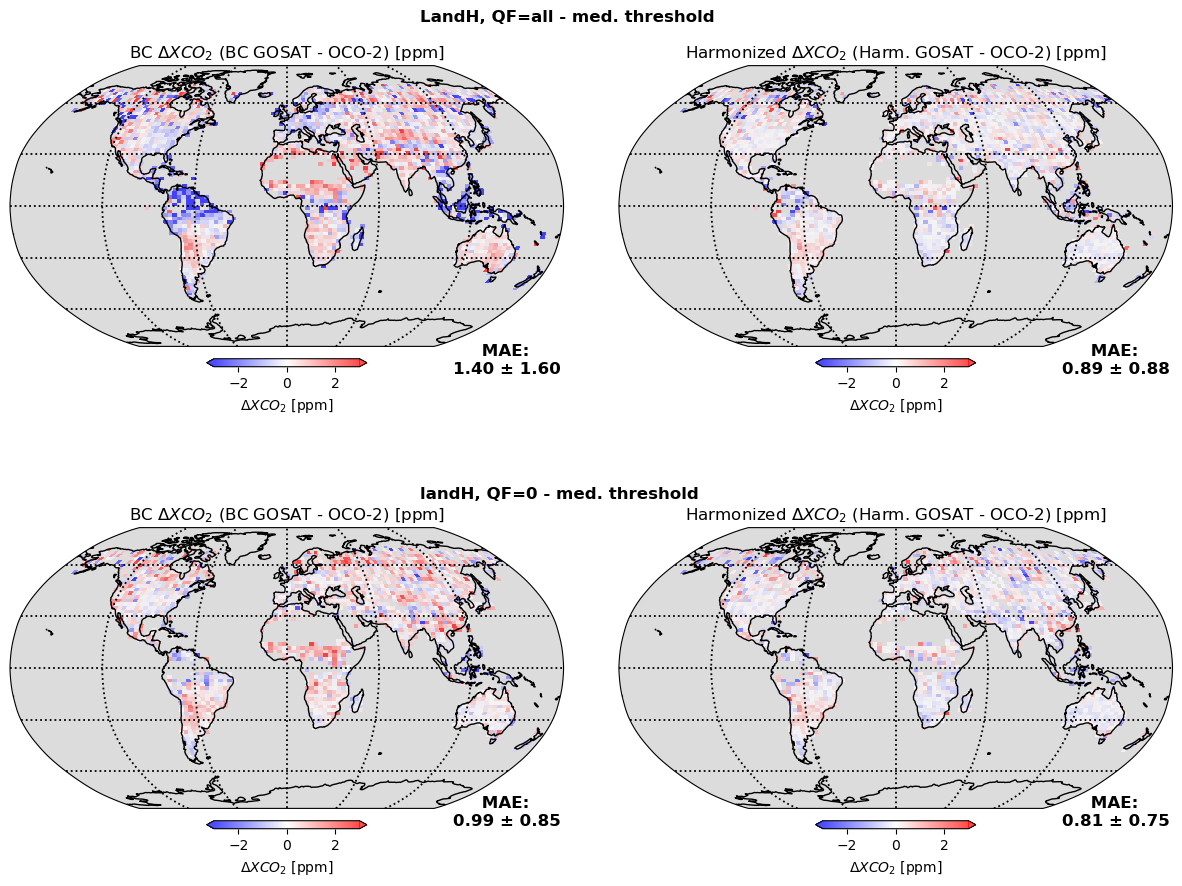

In [49]:
dxco2_bc = land_h_med_threshold_df['gosat_xco2_ak_corrected'].values - land_h_med_threshold_df['oco2_xco2_mean'].values
dxco2_harm = land_h_med_threshold_df['gosat_xco2_harmonized_ak_corrected'].values - land_h_med_threshold_df['oco2_xco2_mean'].values
#y_ml_uncert = colloc_data_qf0['gosat_xco2_harmonized_uncertainty'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(land_h_med_threshold_df['gosat_longitude'],
                                    land_h_med_threshold_df['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_med_threshold_df['gosat_longitude'],
                           land_h_med_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.74, 1.2, 'LandH, QF=all - med. threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')



# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_med_threshold_df['gosat_longitude'],
                           land_h_med_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# QF=0 data
land_h_med_threshold_df_qf0 = land_h_med_threshold_df[land_h_med_threshold_df['gosat_xco2_quality_flag']==0]
dxco2_bc = land_h_med_threshold_df_qf0['gosat_xco2_ak_corrected'].values - land_h_med_threshold_df_qf0['oco2_xco2_mean'].values
dxco2_harm = land_h_med_threshold_df_qf0['gosat_xco2_harmonized_ak_corrected'].values - land_h_med_threshold_df_qf0['oco2_xco2_mean'].values

r1, xedges, yedges = np.histogram2d(land_h_med_threshold_df_qf0['gosat_longitude'],
                                    land_h_med_threshold_df_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO02
d1, _, _, = np.histogram2d(land_h_med_threshold_df_qf0['gosat_longitude'],
                           land_h_med_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.74, -0.5, 'landH, QF=0 - med. threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_med_threshold_df_qf0['gosat_longitude'],
                           land_h_med_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');
if save_plots:
    fig.savefig(os.path.join(plot_dir, f'landH_threshold_med_{land_h_med_threshold}_mae.png'))

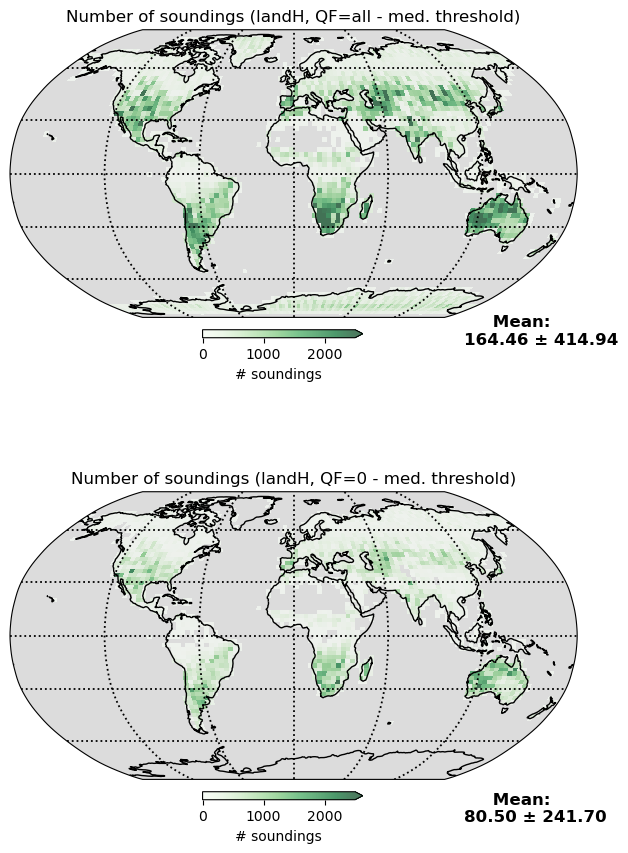

In [51]:
# Plot number of GOSAT soundings after thresholding 

fig, axs = plt.subplots(2, 1, figsize=(8, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(land_h_gosat_med_threshold['gosat_longitude'],
                                    land_h_gosat_med_threshold['gosat_latitude'],
                                    bins=[360//3, 180//3])


# QF = all 
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[0].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.8, 0.01, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title('Number of soundings (landH, QF=all - med. threshold)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')


# QF = 0
land_h_gosat_med_threshold_qf0 = land_h_gosat_med_threshold[land_h_gosat_med_threshold['gosat_xco2_quality_flag']==0]

r1, xedges, yedges = np.histogram2d(land_h_gosat_med_threshold_qf0['gosat_longitude'],
                                    land_h_gosat_med_threshold_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])

_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[1].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, -1.65, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title('Number of soundings (landH, QF=0 - med. threshold)', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'landH_med_threshold_counts.png'))

In [52]:
# Low uncertainty threshold

land_h_low_threshold = 1.2
land_h_low_threshold_df = land_h_colloc[land_h_colloc['gosat_xco2_harmonized_uncertainty'] < land_h_low_threshold]
print(f'Low threshold = {land_h_low_threshold}')
print('\nGOSAT-OCO-2 collocations:')
print(f'{(land_h_low_threshold_df.shape[0] / land_h_colloc.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(land_h_colloc[land_h_colloc['gosat_xco2_quality_flag']==0].shape[0] / land_h_colloc.shape[0])*100:.2f}% data throughput')

# Filter full GOSAT record 
land_h_gosat_low_threshold = land_h_full_gosat[land_h_full_gosat['gosat_xco2_harmonized_uncertainty'] < land_h_low_threshold]
print('\nGOSAT full record:')
print(f'{(land_h_gosat_low_threshold.shape[0] / land_h_full_gosat.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(land_h_full_gosat[land_h_full_gosat['gosat_xco2_quality_flag']==0].shape[0] / land_h_full_gosat.shape[0])*100:.2f}% data throughput')

Low threshold = 1.2

GOSAT-OCO-2 collocations:
43.05% data throughput
QF=0: 42.99% data throughput

GOSAT full record:
24.41% data throughput
QF=0: 21.44% data throughput


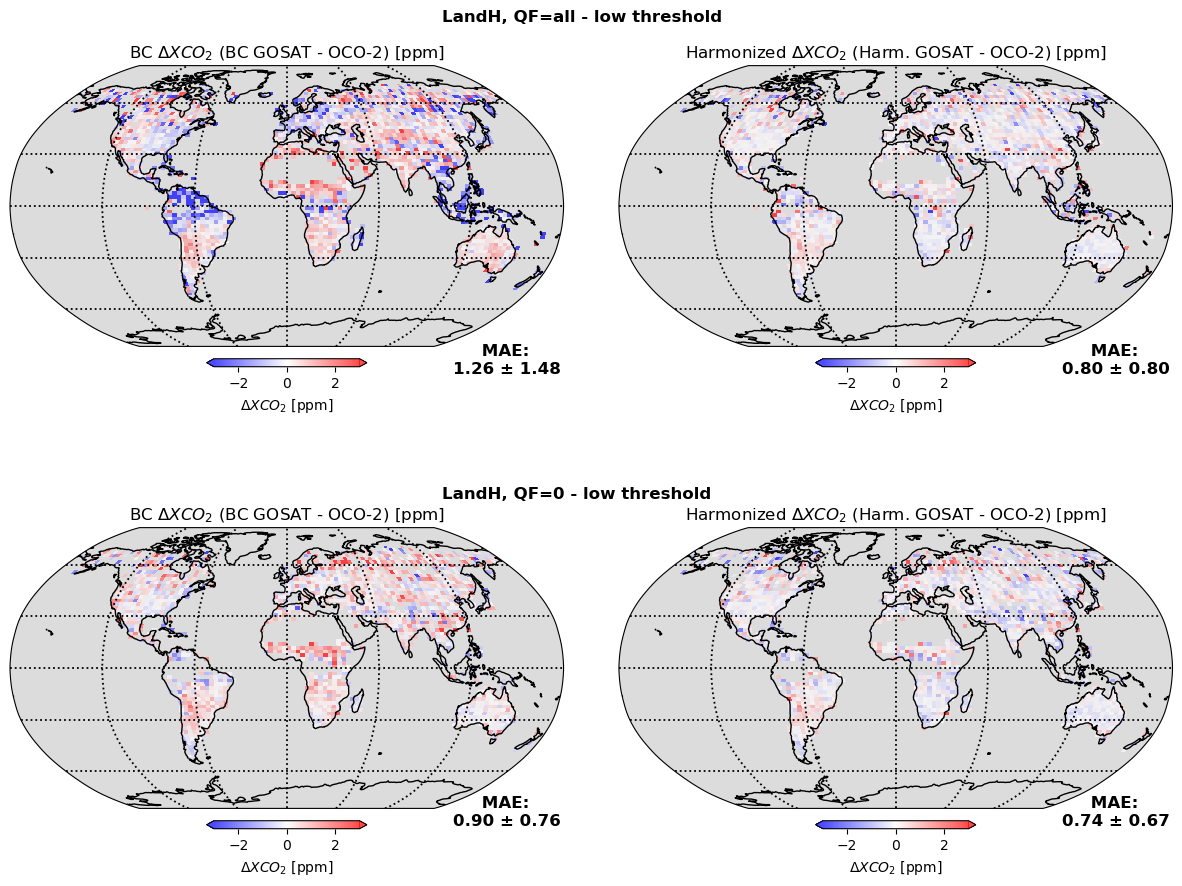

In [55]:
dxco2_bc = land_h_low_threshold_df['gosat_xco2_ak_corrected'].values - land_h_low_threshold_df['oco2_xco2_mean'].values
dxco2_harm = land_h_low_threshold_df['gosat_xco2_harmonized_ak_corrected'].values - land_h_low_threshold_df['oco2_xco2_mean'].values
#y_ml_uncert = colloc_data_qf0['gosat_xco2_harmonized_uncertainty'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(land_h_low_threshold_df['gosat_longitude'],
                                    land_h_low_threshold_df['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_low_threshold_df['gosat_longitude'],
                           land_h_low_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.78, 1.2, 'LandH, QF=all - low threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')



# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_low_threshold_df['gosat_longitude'],
                           land_h_low_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# QF=0 data
land_h_low_threshold_df_qf0 = land_h_low_threshold_df[land_h_low_threshold_df['gosat_xco2_quality_flag']==0]
dxco2_bc = land_h_low_threshold_df_qf0['gosat_xco2_ak_corrected'].values - land_h_low_threshold_df_qf0['oco2_xco2_mean'].values
dxco2_harm = land_h_low_threshold_df_qf0['gosat_xco2_harmonized_ak_corrected'].values - land_h_low_threshold_df_qf0['oco2_xco2_mean'].values

r1, xedges, yedges = np.histogram2d(land_h_low_threshold_df_qf0['gosat_longitude'],
                                    land_h_low_threshold_df_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])

# BC GOSAT - OCO02
d1, _, _, = np.histogram2d(land_h_low_threshold_df_qf0['gosat_longitude'],
                           land_h_low_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.78, -0.5, f'LandH, QF=0 - low threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(land_h_low_threshold_df_qf0['gosat_longitude'],
                           land_h_low_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');
if save_plots:
    fig.savefig(os.path.join(plot_dir, f'landH_threshold_low_{land_h_low_threshold}_mae.png'))

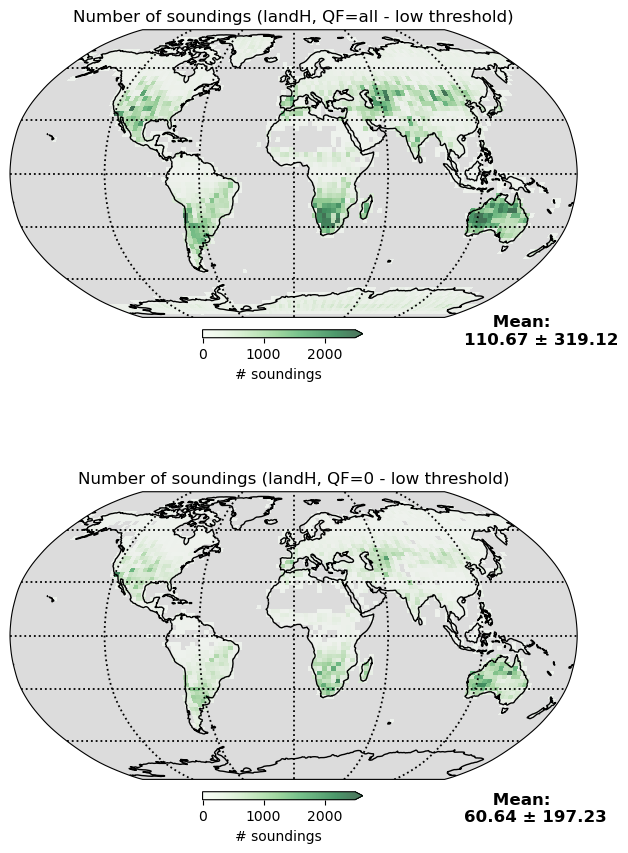

In [56]:
# Plot number of GOSAT soundings after thresholding 

fig, axs = plt.subplots(2, 1, figsize=(8, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

# QF = all 
r1, xedges, yedges = np.histogram2d(land_h_gosat_low_threshold['gosat_longitude'],
                                    land_h_gosat_low_threshold['gosat_latitude'],
                                    bins=[360//3, 180//3])
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[0].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.8, 0.01, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title('Number of soundings (landH, QF=all - low threshold)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')


# QF = 0
land_h_gosat_low_threshold_qf0 = land_h_gosat_low_threshold[land_h_gosat_low_threshold['gosat_xco2_quality_flag']==0]

r1, xedges, yedges = np.histogram2d(land_h_gosat_low_threshold_qf0['gosat_longitude'],
                                    land_h_gosat_low_threshold_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])

_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[1].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, -1.65, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title('Number of soundings (landH, QF=0 - low threshold)', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'landH_low_threshold_counts.png'))

# OceanH - uncertainty thresholding

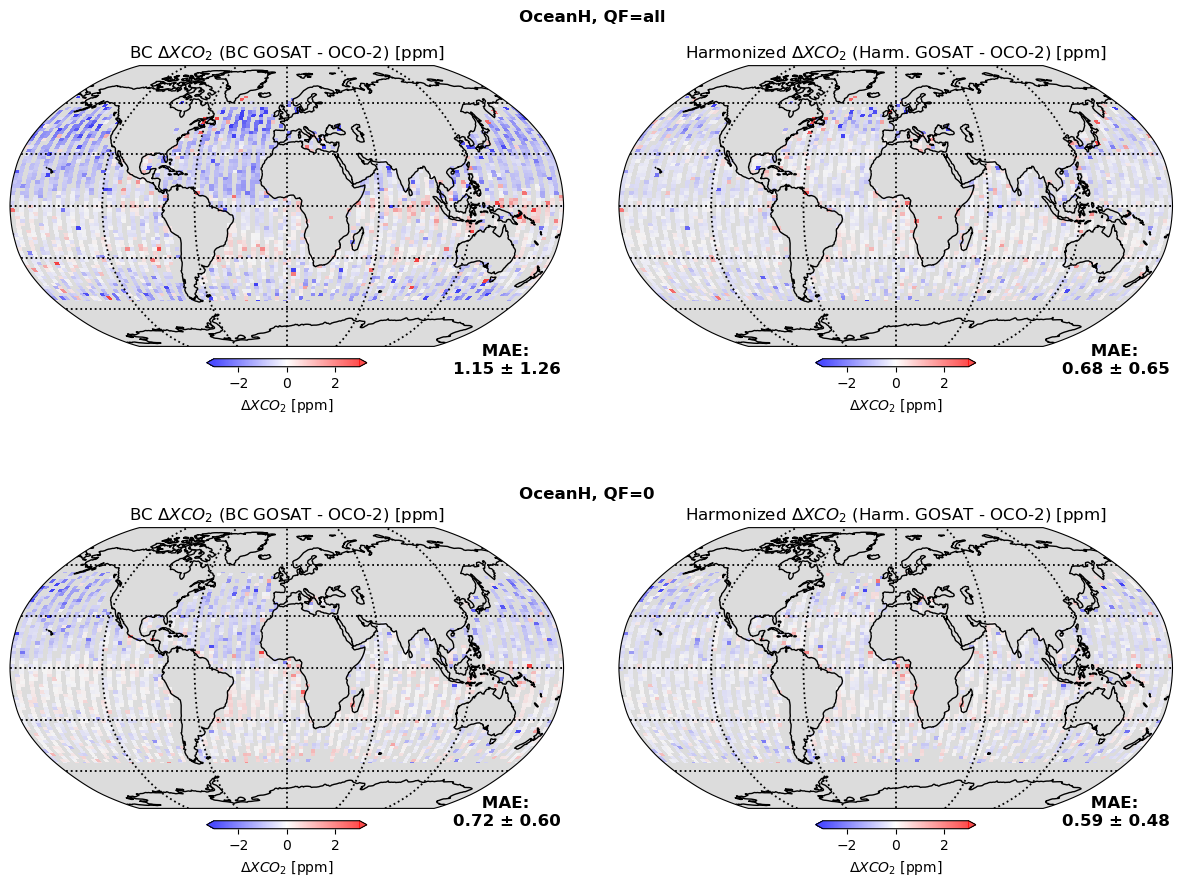

In [72]:
# DXCO2 plots - oceanH

dxco2_bc = ocean_h_colloc['gosat_xco2_ak_corrected'].values - ocean_h_colloc['oco2_xco2_mean'].values
dxco2_harm = ocean_h_colloc['gosat_xco2_harmonized_ak_corrected'].values - ocean_h_colloc['oco2_xco2_mean'].values
#y_ml_uncert = colloc_data_qf0['gosat_xco2_harmonized_uncertainty'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(ocean_h_colloc['gosat_longitude'],
                                    ocean_h_colloc['gosat_latitude'],
                                    bins=[360//3, 180//3])

# BC GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_colloc['gosat_longitude'],
                           ocean_h_colloc['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.92, 1.2, 'OceanH, QF=all', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_colloc['gosat_longitude'],
                           ocean_h_colloc['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# QF=0 data
ocean_h_colloc_qf0 = ocean_h_colloc[ocean_h_colloc['gosat_xco2_quality_flag']==0]
dxco2_bc = ocean_h_colloc_qf0['gosat_xco2_ak_corrected'].values - ocean_h_colloc_qf0['oco2_xco2_mean'].values
dxco2_harm = ocean_h_colloc_qf0['gosat_xco2_harmonized_ak_corrected'].values - ocean_h_colloc_qf0['oco2_xco2_mean'].values

r1, xedges, yedges = np.histogram2d(ocean_h_colloc_qf0['gosat_longitude'],
                                    ocean_h_colloc_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO02
d1, _, _, = np.histogram2d(ocean_h_colloc_qf0['gosat_longitude'],
                           ocean_h_colloc_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.92, -0.5, 'OceanH, QF=0', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_colloc_qf0['gosat_longitude'],
                           ocean_h_colloc_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');

if save_plots:
    fig.savefig(os.path.join(plot_dir, 'GOSAT-OCO2_oceanH_collocation_errors.png'))

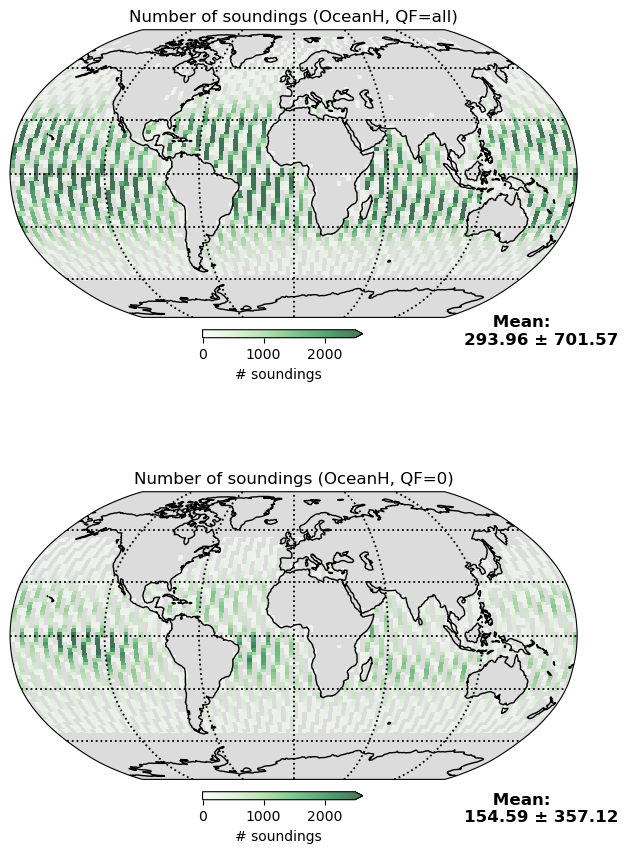

In [73]:
# Plot number of GOSAT soundings 

fig, axs = plt.subplots(2, 1, figsize=(8, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(ocean_h_full_gosat['gosat_longitude'],
                                    ocean_h_full_gosat['gosat_latitude'],
                                    bins=[360//3, 180//3])


# QF = all 
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[0].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.8, 0.01, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title('Number of soundings (OceanH, QF=all)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')


# QF = 0
r1, xedges, yedges = np.histogram2d(ocean_h_full_gosat_qf0['gosat_longitude'],
                                    ocean_h_full_gosat_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])


_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[1].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, -1.65, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title('Number of soundings (OceanH, QF=0)', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'oceanH_all_counts.png'))

(0.0, 4.0)

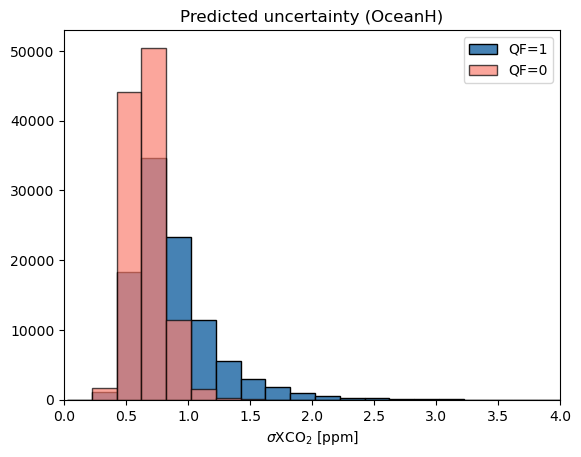

In [64]:
binwidth = 0.2
bins=np.arange(min(ocean_h_colloc[ocean_h_colloc['gosat_xco2_quality_flag']==1]['gosat_xco2_harmonized_uncertainty']), 
           max(ocean_h_colloc[ocean_h_colloc['gosat_xco2_quality_flag']==1]['gosat_xco2_harmonized_uncertainty']) + binwidth, binwidth)

plt.hist(ocean_h_colloc[ocean_h_colloc['gosat_xco2_quality_flag']==1]['gosat_xco2_harmonized_uncertainty'], bins=bins, 
         label = 'QF=1', edgecolor='black', color='steelblue')
plt.hist(ocean_h_colloc[ocean_h_colloc['gosat_xco2_quality_flag']==0]['gosat_xco2_harmonized_uncertainty'], bins=bins, 
         label = 'QF=0', edgecolor='black', color='salmon',alpha=0.7)



plt.title('Predicted uncertainty (OceanH)')
plt.xlabel(r'$\sigma$XCO$_2$ [ppm]')
plt.legend()
plt.xlim(0, 4)

(0.0, 3.0)

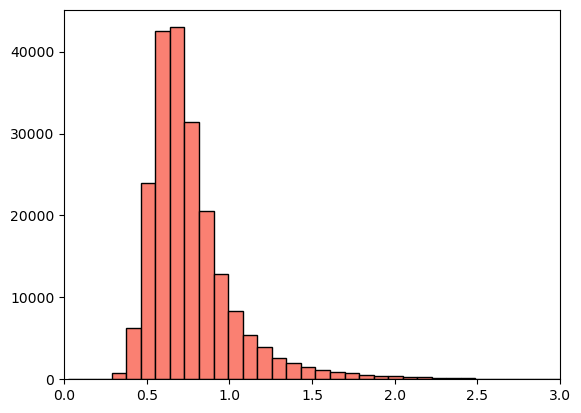

In [67]:
# Use this plot to set sigma thresholds

plt.hist(ocean_h_colloc['gosat_xco2_harmonized_uncertainty'], bins=50, edgecolor='black', color='salmon')
plt.xlim(0, 3)

In [75]:
# High uncertainty threshold

ocean_h_high_threshold = 0.83
ocean_h_high_threshold_df = ocean_h_colloc[ocean_h_colloc['gosat_xco2_harmonized_uncertainty'] < ocean_h_high_threshold]
print(f'High threshold = {ocean_h_high_threshold}')
print('\nGOSAT-OCO-2 collocations:')
print(f'{(ocean_h_high_threshold_df.shape[0] / ocean_h_colloc.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(ocean_h_colloc[ocean_h_colloc['gosat_xco2_quality_flag']==0].shape[0] / ocean_h_colloc.shape[0])*100:.2f}% data throughput')

# Filter full GOSAT record 
ocean_h_gosat_high_threshold = ocean_h_full_gosat[ocean_h_full_gosat['gosat_xco2_harmonized_uncertainty'] < ocean_h_high_threshold]
print('\nGOSAT full record:')
print(f'{(ocean_h_gosat_high_threshold.shape[0] / ocean_h_full_gosat.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(ocean_h_full_gosat[ocean_h_full_gosat['gosat_xco2_quality_flag']==0].shape[0] / ocean_h_full_gosat.shape[0])*100:.2f}% data throughput')

High threshold = 0.83

GOSAT-OCO-2 collocations:
72.16% data throughput
QF=0: 51.87% data throughput

GOSAT full record:
69.14% data throughput
QF=0: 52.59% data throughput


C:\Users\hopki\AppData\Local\Temp\ipykernel_38264\2227029778.py:68: RuntimeWarning: divide by zero encountered in divide
  binned_dxco2 = d1 / r1
C:\Users\hopki\AppData\Local\Temp\ipykernel_38264\2227029778.py:89: RuntimeWarning: divide by zero encountered in divide
  binned_dxco2 = d1 / r1


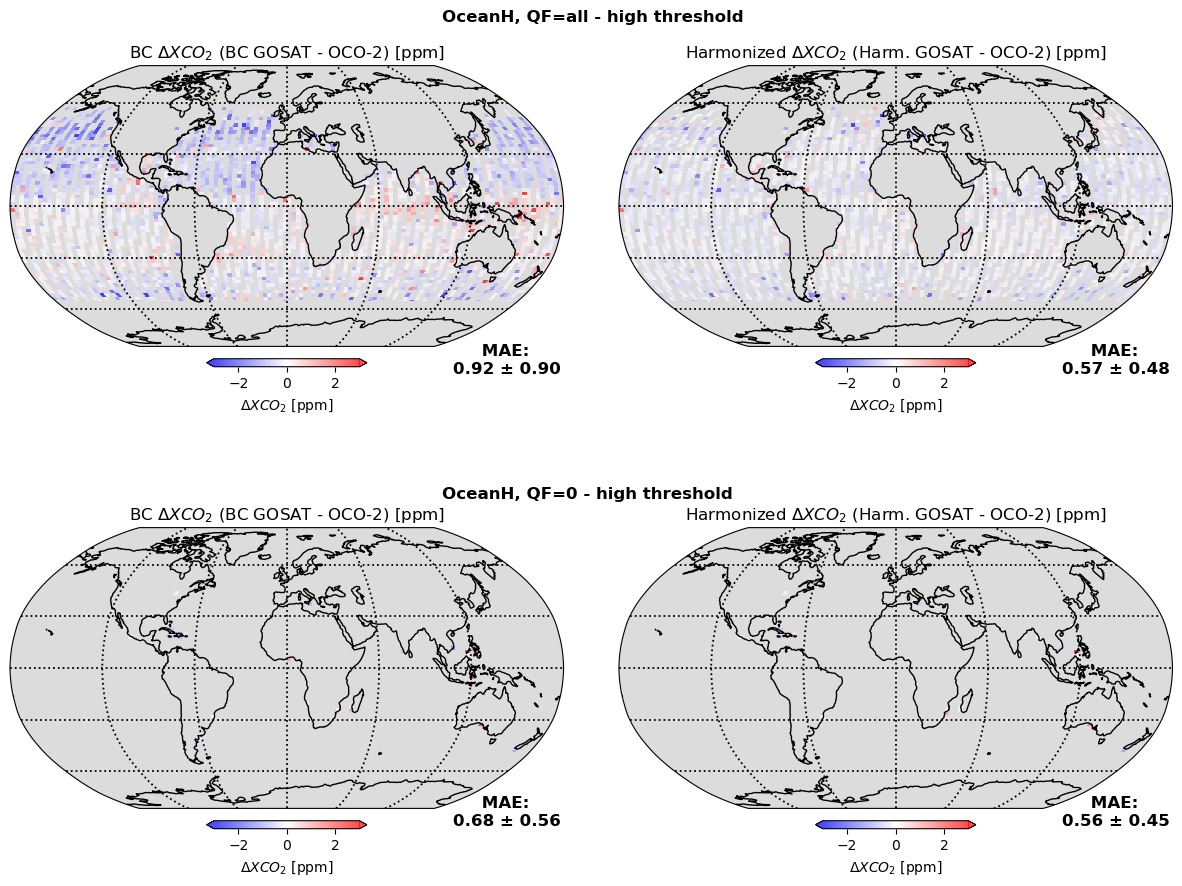

In [76]:
dxco2_bc = ocean_h_high_threshold_df['gosat_xco2_ak_corrected'].values - ocean_h_high_threshold_df['oco2_xco2_mean'].values
dxco2_harm = ocean_h_high_threshold_df['gosat_xco2_harmonized_ak_corrected'].values - ocean_h_high_threshold_df['oco2_xco2_mean'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(ocean_h_high_threshold_df['gosat_longitude'],
                                    ocean_h_high_threshold_df['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_high_threshold_df['gosat_longitude'],
                           ocean_h_high_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.78, 1.2, f'OceanH, QF=all - high threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')

# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_high_threshold_df['gosat_longitude'],
                           ocean_h_high_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')



# QF=0 data
ocean_h_high_threshold_df_qf0 = ocean_h_high_threshold_df[ocean_h_high_threshold_df['gosat_xco2_quality_flag']==0]
dxco2_bc = ocean_h_high_threshold_df_qf0['gosat_xco2_ak_corrected'].values - ocean_h_high_threshold_df_qf0['oco2_xco2_mean'].values
dxco2_harm = ocean_h_high_threshold_df_qf0['gosat_xco2_harmonized_ak_corrected'].values - ocean_h_high_threshold_df_qf0['oco2_xco2_mean'].values

r1, xedges, yedges = np.histogram2d(land_h_high_threshold_df_qf0['gosat_longitude'],
                                    land_h_high_threshold_df_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO02
d1, _, _, = np.histogram2d(ocean_h_high_threshold_df_qf0['gosat_longitude'],
                           ocean_h_high_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.78, -0.5, f'OceanH, QF=0 - high threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_high_threshold_df_qf0['gosat_longitude'],
                           ocean_h_high_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'oceanH_threshold_high_{ocean_h_high_threshold}_mae.png'))

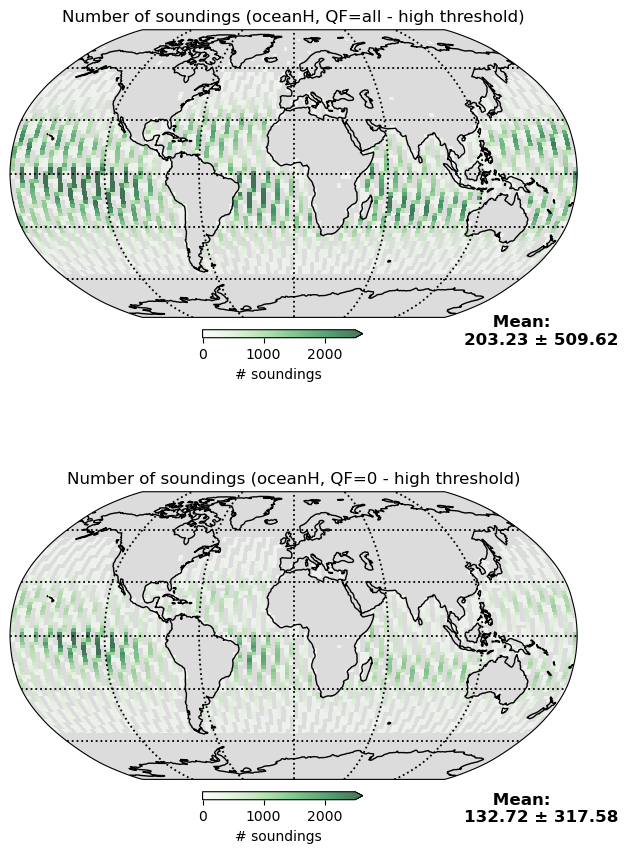

In [77]:
# Plot number of GOSAT soundings after thresholding 

fig, axs = plt.subplots(2, 1, figsize=(8, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

# QF = all 
r1, xedges, yedges = np.histogram2d(ocean_h_gosat_high_threshold['gosat_longitude'],
                                    ocean_h_gosat_high_threshold['gosat_latitude'],
                                    bins=[360//3, 180//3])
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[0].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.8, 0.01, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title('Number of soundings (oceanH, QF=all - high threshold)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')


# QF = 0
ocean_h_gosat_high_threshold_qf0 = ocean_h_gosat_high_threshold[ocean_h_gosat_high_threshold['gosat_xco2_quality_flag']==0]

r1, xedges, yedges = np.histogram2d(ocean_h_gosat_high_threshold_qf0['gosat_longitude'],
                                    ocean_h_gosat_high_threshold_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[1].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, -1.65, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title('Number of soundings (oceanH, QF=0 - high threshold)', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'oceanH_high_threshold_counts.png'))

In [79]:
# Medium uncertainty threshold

ocean_h_med_threshold = 0.75
ocean_h_med_threshold_df = ocean_h_colloc[ocean_h_colloc['gosat_xco2_harmonized_uncertainty'] < ocean_h_med_threshold]
print(f'Medium threshold = {ocean_h_med_threshold}')
print('\nGOSAT-OCO-2 collocations:')
print(f'{(ocean_h_med_threshold_df.shape[0] / ocean_h_colloc.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(ocean_h_colloc[ocean_h_colloc['gosat_xco2_quality_flag']==0].shape[0] / ocean_h_colloc.shape[0])*100:.2f}% data throughput')

# Filter full GOSAT record 
ocean_h_gosat_med_threshold = ocean_h_full_gosat[ocean_h_full_gosat['gosat_xco2_harmonized_uncertainty'] < ocean_h_med_threshold]
print('\nGOSAT full record:')
print(f'{(ocean_h_gosat_med_threshold.shape[0] / ocean_h_full_gosat.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(ocean_h_full_gosat[ocean_h_full_gosat['gosat_xco2_quality_flag']==0].shape[0] / ocean_h_full_gosat.shape[0])*100:.2f}% data throughput')

Medium threshold = 0.75

GOSAT-OCO-2 collocations:
59.63% data throughput
QF=0: 51.87% data throughput

GOSAT full record:
55.99% data throughput
QF=0: 52.59% data throughput


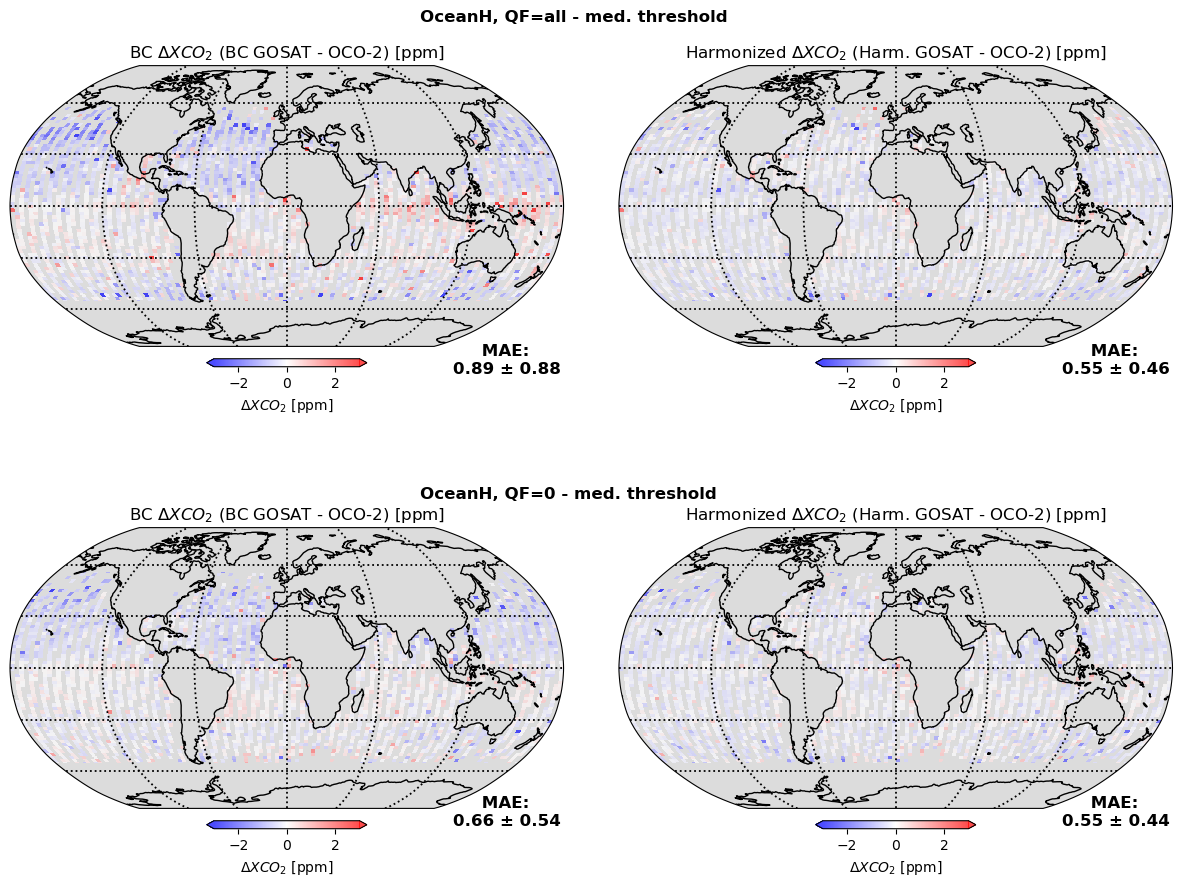

In [80]:
dxco2_bc = ocean_h_med_threshold_df['gosat_xco2_ak_corrected'].values - ocean_h_med_threshold_df['oco2_xco2_mean'].values
dxco2_harm = ocean_h_med_threshold_df['gosat_xco2_harmonized_ak_corrected'].values - ocean_h_med_threshold_df['oco2_xco2_mean'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(ocean_h_med_threshold_df['gosat_longitude'],
                                    ocean_h_med_threshold_df['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_med_threshold_df['gosat_longitude'],
                           ocean_h_med_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.74, 1.2, 'OceanH, QF=all - med. threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')



# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_med_threshold_df['gosat_longitude'],
                           ocean_h_med_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# QF=0 data
ocean_h_med_threshold_df_qf0 = ocean_h_med_threshold_df[ocean_h_med_threshold_df['gosat_xco2_quality_flag']==0]
dxco2_bc = ocean_h_med_threshold_df_qf0['gosat_xco2_ak_corrected'].values - ocean_h_med_threshold_df_qf0['oco2_xco2_mean'].values
dxco2_harm = ocean_h_med_threshold_df_qf0['gosat_xco2_harmonized_ak_corrected'].values - ocean_h_med_threshold_df_qf0['oco2_xco2_mean'].values

r1, xedges, yedges = np.histogram2d(ocean_h_med_threshold_df_qf0['gosat_longitude'],
                                    ocean_h_med_threshold_df_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])

# BC GOSAT - OCO02
d1, _, _, = np.histogram2d(ocean_h_med_threshold_df_qf0['gosat_longitude'],
                           ocean_h_med_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.74, -0.5, 'OceanH, QF=0 - med. threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_med_threshold_df_qf0['gosat_longitude'],
                           ocean_h_med_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');
if save_plots:
    fig.savefig(os.path.join(plot_dir, f'oceanH_threshold_med_{ocean_h_med_threshold}_mae.png'))

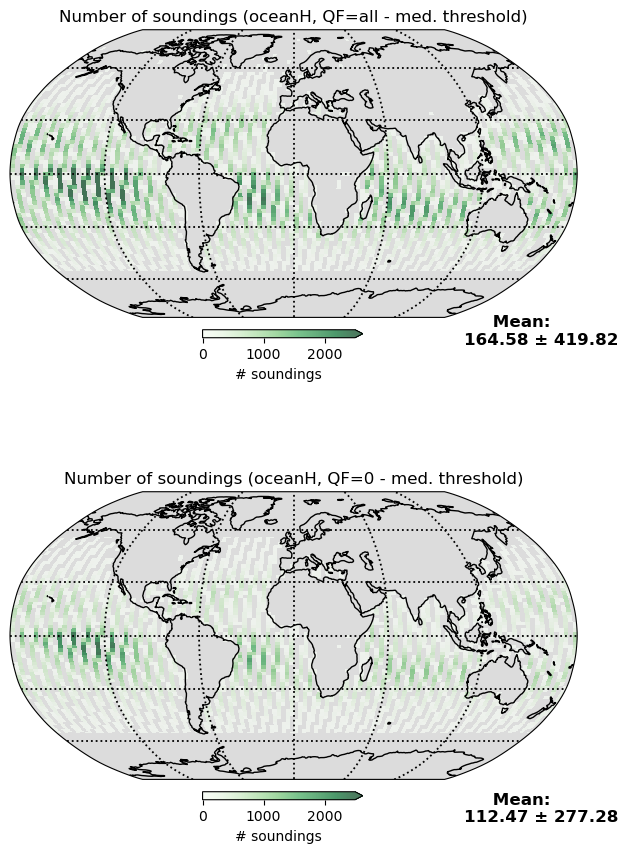

In [81]:
# Plot number of GOSAT soundings after thresholding 

fig, axs = plt.subplots(2, 1, figsize=(8, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

# QF = all 
r1, xedges, yedges = np.histogram2d(ocean_h_gosat_med_threshold['gosat_longitude'],
                                    ocean_h_gosat_med_threshold['gosat_latitude'],
                                    bins=[360//3, 180//3])
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[0].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.8, 0.01, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title('Number of soundings (oceanH, QF=all - med. threshold)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')


# QF = 0
ocean_h_gosat_med_threshold_qf0 = ocean_h_gosat_med_threshold[ocean_h_gosat_med_threshold['gosat_xco2_quality_flag']==0]

r1, xedges, yedges = np.histogram2d(ocean_h_gosat_med_threshold_qf0['gosat_longitude'],
                                    ocean_h_gosat_med_threshold_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[1].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, -1.65, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title('Number of soundings (oceanH, QF=0 - med. threshold)', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'oceanH_med_threshold_counts.png'))

In [84]:
# Low uncertainty threshold

ocean_h_low_threshold = 0.71
ocean_h_low_threshold_df = ocean_h_colloc[ocean_h_colloc['gosat_xco2_harmonized_uncertainty'] < ocean_h_low_threshold]
print(f'Low threshold = {land_h_low_threshold}')
print('\nGOSAT-OCO-2 collocations:')
print(f'{(ocean_h_low_threshold_df.shape[0] / ocean_h_colloc.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(ocean_h_colloc[ocean_h_colloc['gosat_xco2_quality_flag']==0].shape[0] / ocean_h_colloc.shape[0])*100:.2f}% data throughput')

# Filter full GOSAT record 
ocean_h_gosat_low_threshold = ocean_h_full_gosat[ocean_h_full_gosat['gosat_xco2_harmonized_uncertainty'] < ocean_h_low_threshold]
print('\nGOSAT full record:')
print(f'{(ocean_h_gosat_low_threshold.shape[0] / ocean_h_full_gosat.shape[0])*100:.2f}% data throughput')
print(f'QF=0: {(ocean_h_full_gosat[ocean_h_full_gosat['gosat_xco2_quality_flag']==0].shape[0] / ocean_h_full_gosat.shape[0])*100:.2f}% data throughput')

Low threshold = 1.2

GOSAT-OCO-2 collocations:
51.45% data throughput
QF=0: 51.87% data throughput

GOSAT full record:
47.82% data throughput
QF=0: 52.59% data throughput


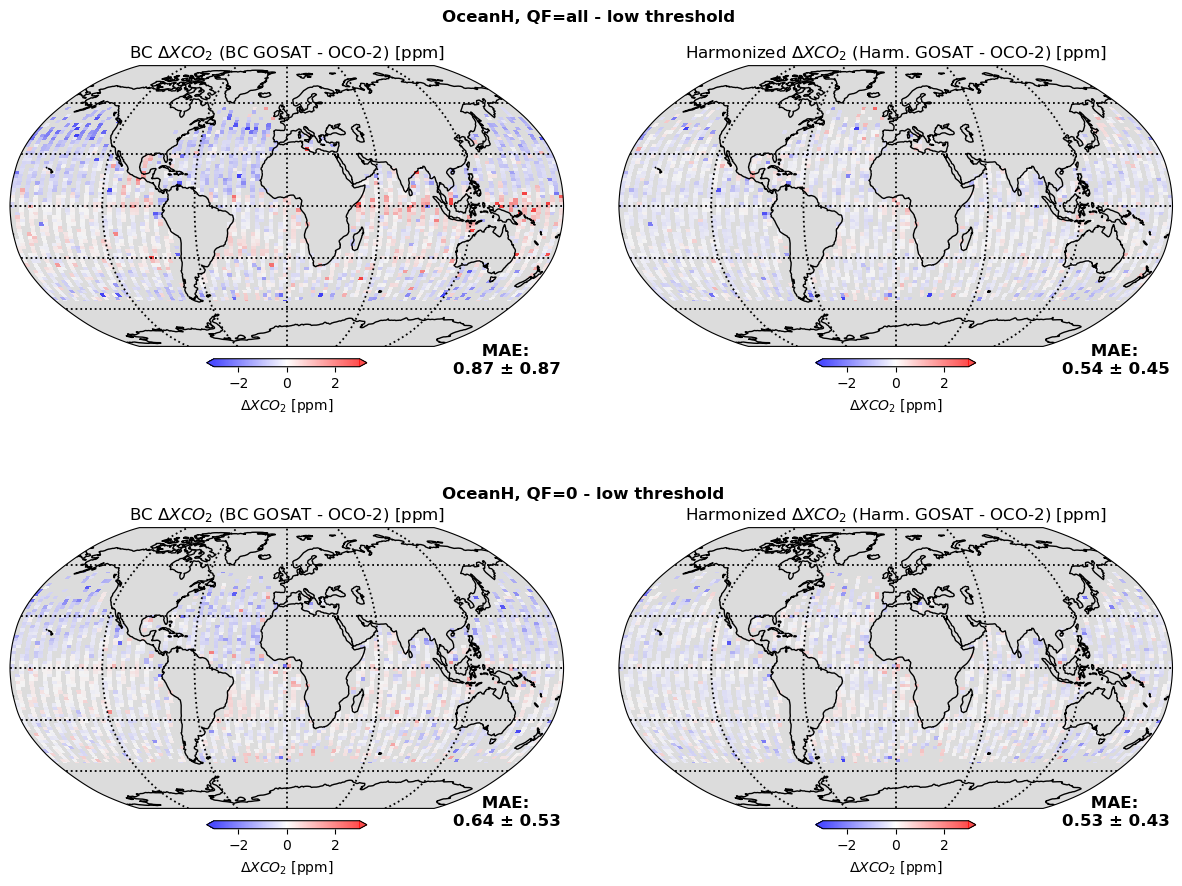

In [86]:
dxco2_bc = ocean_h_low_threshold_df['gosat_xco2_ak_corrected'].values - ocean_h_low_threshold_df['oco2_xco2_mean'].values
dxco2_harm = ocean_h_low_threshold_df['gosat_xco2_harmonized_ak_corrected'].values - ocean_h_low_threshold_df['oco2_xco2_mean'].values
#y_ml_uncert = colloc_data_qf0['gosat_xco2_harmonized_uncertainty'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(ocean_h_low_threshold_df['gosat_longitude'],
                                    ocean_h_low_threshold_df['gosat_latitude'],
                                    bins=[360//3, 180//3])


# BC GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_low_threshold_df['gosat_longitude'],
                           ocean_h_low_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.78, 1.2, 'OceanH, QF=all - low threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')

axs[0].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')

# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_low_threshold_df['gosat_longitude'],
                           ocean_h_low_threshold_df['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, 0.01, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# QF=0 data
ocean_h_low_threshold_df_qf0 = ocean_h_low_threshold_df[ocean_h_low_threshold_df['gosat_xco2_quality_flag']==0]
dxco2_bc = ocean_h_low_threshold_df_qf0['gosat_xco2_ak_corrected'].values - ocean_h_low_threshold_df_qf0['oco2_xco2_mean'].values
dxco2_harm = ocean_h_low_threshold_df_qf0['gosat_xco2_harmonized_ak_corrected'].values - ocean_h_low_threshold_df_qf0['oco2_xco2_mean'].values

r1, xedges, yedges = np.histogram2d(ocean_h_low_threshold_df_qf0['gosat_longitude'],
                                    ocean_h_low_threshold_df_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])

# BC GOSAT - OCO02
d1, _, _, = np.histogram2d(ocean_h_low_threshold_df_qf0['gosat_longitude'],
                           ocean_h_low_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_bc))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.78, -0.5, f'OceanH, QF=0 - low threshold', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_bc).mean():.2f} ± {np.abs(dxco2_bc).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[2].set_facecolor('gainsboro')  # whitesmoke
axs[2].set_title(r'BC $\Delta XCO_{2}$ (BC GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# Harmonized GOSAT - OCO-2
d1, _, _, = np.histogram2d(ocean_h_low_threshold_df_qf0['gosat_longitude'],
                           ocean_h_low_threshold_df_qf0['gosat_latitude'],
                           bins=[xedges, yedges], weights=(dxco2_harm))
d1[d1==0.0] = np.nan
binned_dxco2 = d1 / r1

im = axs[3].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-3, vmax=3, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[3].coastlines(color = 'black', linewidth = 1.0)
axs[3].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[3].text(0.8, -1.6, f'     MAE: \n{np.abs(dxco2_harm).mean():.2f} ± {np.abs(dxco2_harm).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[3].set_facecolor('gainsboro')  # whitesmoke
axs[3].set_title(r'Harmonized $\Delta XCO_{2}$ (Harm. GOSAT - OCO-2) [ppm]', fontsize=12)
fig.colorbar(im, ax=axs[3], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]');
if save_plots:
    fig.savefig(os.path.join(plot_dir, f'oceanH_threshold_low_{ocean_h_low_threshold}_mae.png'))

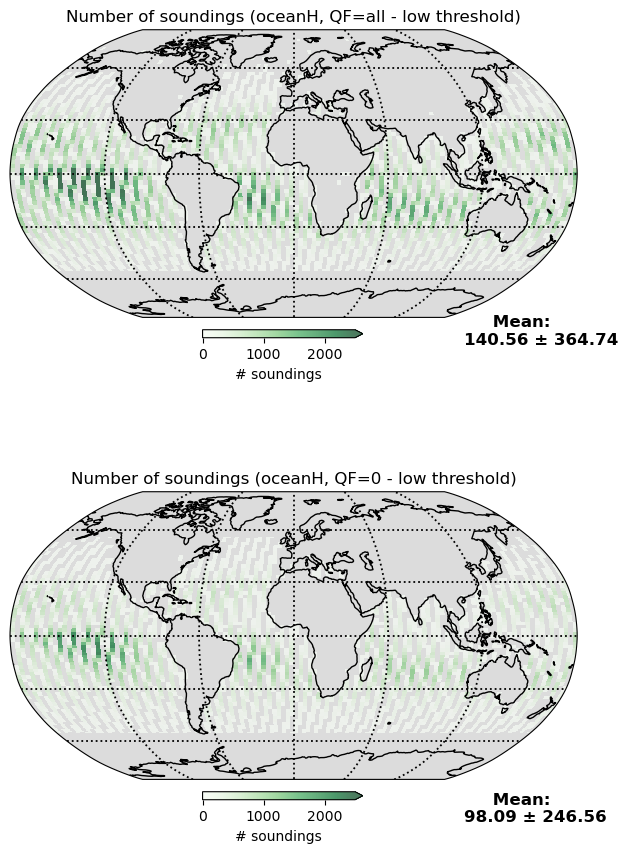

In [87]:
# Plot number of GOSAT soundings after thresholding 

fig, axs = plt.subplots(2, 1, figsize=(8, 10), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

# QF = all 
r1, xedges, yedges = np.histogram2d(ocean_h_gosat_low_threshold['gosat_longitude'],
                                    ocean_h_gosat_low_threshold['gosat_latitude'],
                                    bins=[360//3, 180//3])
_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[0].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.8, 0.01, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('gainsboro')  # whitesmoke
axs[0].set_title('Number of soundings (oceanH, QF=all - low threshold)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')


# QF = 0
ocean_h_gosat_low_threshold_qf0 = ocean_h_gosat_low_threshold[ocean_h_gosat_low_threshold['gosat_xco2_quality_flag']==0]

r1, xedges, yedges = np.histogram2d(ocean_h_gosat_low_threshold_qf0['gosat_longitude'],
                                    ocean_h_gosat_low_threshold_qf0['gosat_latitude'],
                                    bins=[360//3, 180//3])

_r1 = r1.copy()
_r1[_r1==0.0] = np.nan

im = axs[1].imshow(_r1.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Greens', vmin=0, vmax=2500, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.8, -1.65, f'     Mean: \n{(r1).mean():.2f} ± {(r1).std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('gainsboro')  # whitesmoke
axs[1].set_title('Number of soundings (oceanH, QF=0 - low threshold)', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='# soundings')

if save_plots:
    fig.savefig(os.path.join(plot_dir, f'oceanH_low_threshold_counts.png'))